<a href="https://colab.research.google.com/github/ReutFarkash/stocks/blob/master/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras
How to Predict Stock Prices in Python using TensorFlow 2 and Keras
Predicting different stock prices using Long Short-Term Memory Recurrent Neural Network in Python using TensorFlow 2 and Keras.

In [1]:
!pip3 install tensorflow pandas numpy matplotlib yahoo_fin sklearn requests_html

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random

In [3]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [4]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the data, default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # train / test (TimeSeries) split
    train_df, test_df = np.split(df, [int(len(df)*0.7)])
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            train_df[column] = scaler.fit_transform(np.expand_dims(train_df[column].values, axis=1))
            test_df[column] = scaler.transform(np.expand_dims(test_df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    train_df['future'] = train_df['adjclose'].shift(-lookup_step)
    test_df['future'] = test_df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence_train = np.array(train_df[feature_columns].tail(lookup_step))
    last_sequence_test = np.array(test_df[feature_columns].tail(lookup_step))
    # drop NaNs
    train_df.dropna(inplace=True)
    sequence_data_train = []
    sequences_train = deque(maxlen=n_steps)
    for entry, target in zip(train_df[feature_columns].values, train_df['future'].values):
        sequences_train.append(entry)
        if len(sequences_train) == n_steps:
            sequence_data_train.append([np.array(sequences_train), target])
    test_df.dropna(inplace=True)
    sequence_data_test = []
    sequences_test = deque(maxlen=n_steps)
    for entry, target in zip(test_df[feature_columns].values, test_df['future'].values):
        sequences_test.append(entry)
        if len(sequences_test) == n_steps:
            sequence_data_test.append([np.array(sequences_test), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices not available in the dataset
    last_sequence_train = list(sequences_train) + list(last_sequence_train)
    last_sequence_train = np.array(last_sequence_train)
    # add to result
    result['last_sequence_train'] = last_sequence_train
    last_sequence_test = list(sequences_test) + list(last_sequence_test)
    last_sequence_test = np.array(last_sequence_test)
    # add to result
    result['last_sequence_test'] = last_sequence_test
    # construct the X's and y's
    X_train, y_train = [], []
    for seq, target in sequence_data_train:
        X_train.append(seq)
        y_train.append(target)
    # convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    # reshape X to fit the neural network
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[2], X_train.shape[1]))
    # construct the X's and y's
    X_test, y_test = [], []
    for seq, target in sequence_data_train:
        X_test.append(seq)
        y_test.append(target)
    # convert to numpy arrays
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    # reshape X to fit the neural network
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[2], X_test.shape[1]))
    # split the dataset
    p = np.random.permutation(len(X_train))
    X_train = X_train[p]
    y_train = y_train[p]
    #idx = np.random.permutation(X_train.index)
    #X_train.reindex(idx, inplace=True)
    #Y_train.reindex(idx, inplace=True)
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = X_train, X_test, y_train, y_test
    # return the result
    return result

In [5]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [6]:
# Window size or the sequence length
N_STEPS = 70
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 50
# Tesla stock market
ticker = "TSLA"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [7]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [8]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)
model.save(os.path.join("results", model_name) + ".h5")

Epoch 1/50
 1/27 [>.............................] - ETA: 0s - loss: 0.1035 - mean_absolute_error: 0.3602WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
23/27 [========================>.....] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.1061
Epoch 00001: val_loss improved from inf to 0.00282, saving model to results/2020-09-05_TSLA-huber_loss-adam-LSTM-seq-70-step-1-layers-3-units-256.h5
27/27 [==============================] - 1s 44ms/step - loss: 0.0110 - mean_absolute_error: 0.1001 - val_loss: 0.0028 - val_mean_absolute_error: 0.0548
Epoch 2/50
24/27 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0598
Epoch 00002: val_loss improved from 0.00282 to 0.00255, saving model to results/2020-09-05_TSLA-huber_loss-adam-LSTM-s

In [9]:
#tensorboard --logdir="logs"

In [10]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [11]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
print("Mean Absolute Error:", mean_absolute_error)

Mean Absolute Error: 4.355269626299664


In [14]:
def predict(model, data, on='_train'):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence" + on][-N_STEPS:]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price

In [15]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 1 days is 71.73$


In [16]:
def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    # last 200 days, feel free to edit that
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

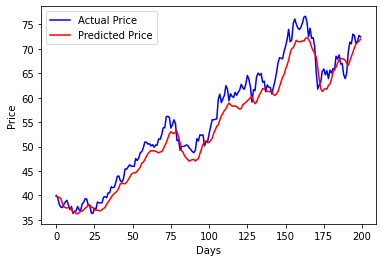

In [17]:
plot_graph(model, data)

In [18]:
def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)

In [19]:
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))

1: Accuracy Score: 0.504927536231884
